# Graph Centrality and BEA Input-Output Use Tables

- igraph, network, centrality, BEA Input-Output Use Table
- Choi and Foerster (2017), Bureau of Economic Analysis, and others

Terence Lim

In [2]:
import os
import time
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import igraph  # pip3 install cairocffi
from igraph import Graph
from finds.database import Redis
from finds.sectors import Sectoring, BEA
from finds.graph import igraph_draw, igraph_info, igraph_centrality
from settings import settings

ECHO=False
years = np.arange(1947, 2020) 
vintages = [1997, 1963, 1947]   # when sectoring schemes were revised
rdb = Redis(**settings['redis'])
bea = BEA(rdb, **settings['bea'], echo=ECHO)
logdir = os.path.join(settings['images'], 'bea')

# Read IOUse tables from BEA website
ioUses = dict()
for vintage in vintages:
    for year in [y for y in years if y >= vintage]:
        df = bea.read_ioUse(year, vintage=vintage)
        ioUses[(vintage, year)] = df
    print(f"{len(ioUses)} tables through sectoring vintage year {vintage}")

23 tables through sectoring vintage year 1997
80 tables through sectoring vintage year 1963
153 tables through sectoring vintage year 1947


## Set directed edges with tail on user (table column) and head on maker (table row)
- Direction of edges point from user industry to maker industry -- i.e. follows the $money$

In [3]:
tail = 'colcode'   # edges follow flow of payments, from column to row
head = 'rowcode'  
drop = ('F','T','U','V','Other')  # drop these codes
colors = ['lightgrey', 'darkgreen', 'lightgreen']    
yearc = {}  # collect annual table

## Populate and plot graphs of first and last table years

     vertices edges  density diameter simple directed global clustering local clustering weak components largest weak strong components largest strong
1947       47  1724  1.59482        3   True     True          0.949086         0.951084               1           47                 3             45


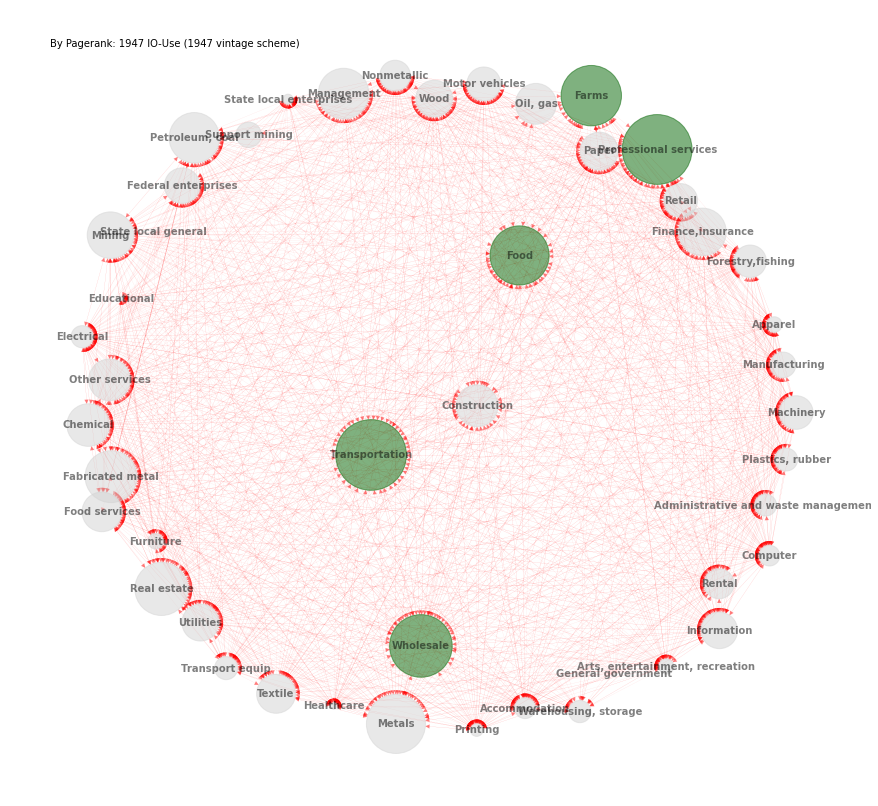

     vertices edges   density diameter simple directed global clustering local clustering weak components largest weak strong components largest strong
2019       47  1689  1.562442        2   True     True          0.956645         0.958803               1           47                 3             45


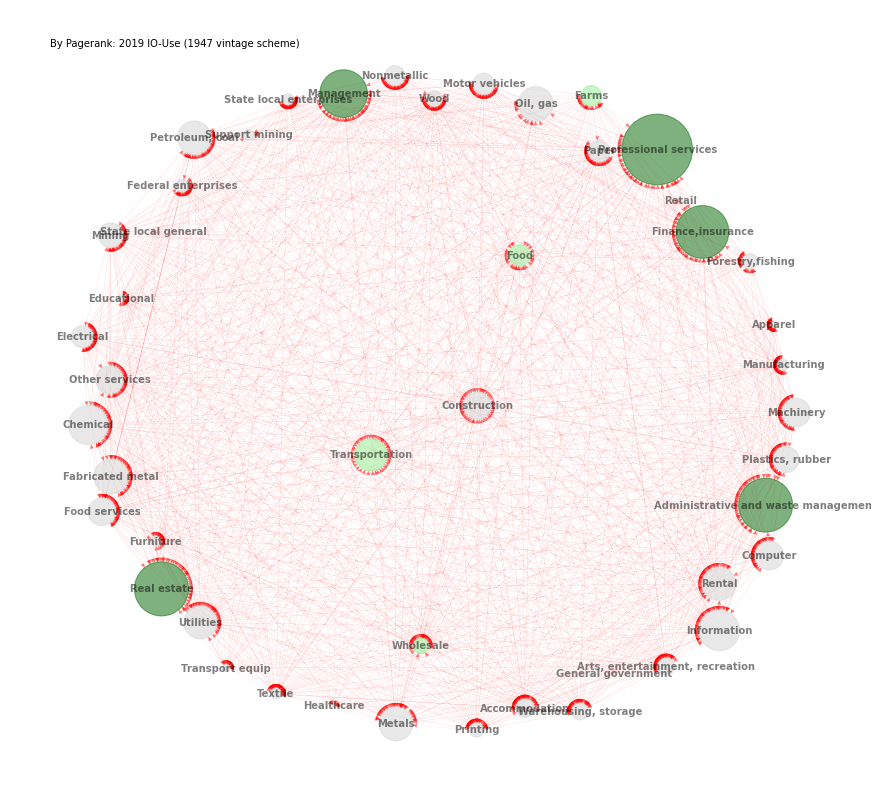

In [5]:
for ifig, year in enumerate([1947, 2019]): #np.arange(1947, 2020)):
    # keep year, drop invalid rows
    ioUse = ioUses[(vintage, year)]
    data = ioUse[(~ioUse['rowcode'].str.startswith(drop) &
                  ~ioUse['colcode'].str.startswith(drop))].copy()

    # create master table of industries and measurements
    master = data[data['rowcode']==data['colcode']][['rowcode','datavalue']]\
             .set_index('rowcode')\
             .rename(columns={'datavalue': 'self'})

    # extract cross data; generate and load edges (as tuples) to graph
    data = data[(data['colcode'] != data['rowcode'])]
    data['weights'] = data['datavalue'] / data['datavalue'].sum()
    edges = data.loc[data['weights'] > 0,
                     [tail, head, 'weights', 'datavalue']].values
    g = Graph.TupleList(edges, edge_attrs=['weight', 'value'], directed=True)
    g.vs['bea'] = list(BEA.bea_industry[g.vs['name']])

    Series(igraph_info(g)).to_frame().T

    # update master table industry flow values
    master = master.join(data.groupby(['colcode'])['datavalue'].sum(),
                         how='outer').rename(columns={'datavalue': 'user'})
    master = master.join(data.groupby(['rowcode'])['datavalue'].sum(),
                         how='outer').rename(columns={'datavalue': 'maker'})
    master = master.fillna(0).astype(int)
    # inweight~supply~authority~eigenvector~pagerank, outweight~demand~hub
    master = master.join(DataFrame(index=list(g.vs['name']),
                                   data=igraph_centrality(g)), how='left')
    master['bea'] = BEA.bea_industry[master.index].to_list()
    yearc[year] = master[['outweight','inweight', 'pagerank', 'hub',
                          'authority', 'bea']].set_index('bea')

    # visualize graph
    score = g.pagerank(weights='weight', damping=0.99)   
    node_size = pd.Series(data=score, index=g.vs['name']).to_dict()
    node_color = {k: colors[0] for k in g.vs["name"]}
    if ifig == 0:
        center_name = g.vs['name'][np.argmax(score)]
    else:
        node_color.update({k: colors[2] for k in top_color})
    top_color = g.vs[list(np.argsort(score)[-5:])]["name"]
    node_color.update({k: colors[1] for k in top_color})
    
    pos = igraph_draw(
        g, num=ifig+1, center_name=center_name,
        node_color=node_color, node_size=node_size, edge_color='r', k=3,
        pos=(pos if ifig else None),font_size=10, font_weight='semibold',
        labels={k:v for k,v in zip(g.vs['name'], g.vs['bea'])},
        title=f"By Pagerank: {year} IO-Use ({vintage} vintage scheme)")
    if logdir: plt.savefig(os.path.join(logdir, str(year) + '.jpg'))
    print(Series(igraph_info(g)).rename(str(year)).to_frame().T.to_string())
    plt.show()

## Display node centrality relative ranks

- note decline in centrality of Food, Farms and Transportation, and rise in Finance, Real Estate, and Management

In [6]:
c = yearc[1947].rank(ascending=False).astype(int).join(
    yearc[2019].rank(ascending=False).astype(int), rsuffix='2019')
c.columns = pd.MultiIndex.from_product([[1947,2019], yearc[1947].columns])
c

1947                                  \
                                    outweight inweight pagerank hub authority   
bea                                                                             
Farms                                       4        1        4   6         1   
Forestry,fishing                           42       20       27  13         7   
Oil, gas                                   29       18       16  41        35   
Mining                                     31       19       12  29        26   
Support mining                             36       37       31  39        45   
Utilities                                  26       24       20  31        18   
Construction                                3       16       14   4        29   
Food                                        1        2        5   1        14   
Textile                                    12        8       18   2        11   
Apparel                                     5       38       39   5        36   
Wood                                       22       17       21  16        16   
Paper                                      23       13       19  22         6   
Printing                                   35       42       42  33        37   
Petroleum, coal                             9       14       10  19        21   
Chemical                                   11       10       13   8         9   
Plastics, rubber                           39       30       33  35        30   
Nonmetallic                                33       22       28  34        12   
Metals                                     14        5        6  12        22   
Fabricated metal                            8        7        8  14         5   
Machinery                                  15       27       26  15        27   
Computer                                   40       34       38  40        34   
Electrical                                 21       31       35  23        33   
Motor vehicles                              7       26       24   9        25   
Transport equip                            28       35       32  32        41   
Furniture                                  34       41       40  36        39   
Manufacturing                              20       28       30  17        28   
Wholesale                                  16        3        3  11         3   
Retail                                      2       23       25   3        15   
Transportation                             10        4        1  18         2   
Warehousing, storage                       47       40       34  47        43   
Information                                17       25       22  21        19   
Finance,insurance                          24       12       11  28        13   
Real estate                                13        9        7  25        17   
Rental                                     44       29       29  44        24   
Professional services                      25        6        2  30         4   
Management                                 30       11        9  24         8   
Administrative and waste management        41       33       36  43        20   
Educational                                43       45       45  27        44   
Healthcare                                 27       44       44  10        40   
Arts, entertainment, recreation            32       39       41  38        38   
Accommodation                              38       36       37  42        31   
Food services                               6       21       17   7        23   
Other services                             18       15       15  26        10   
Federal enterprises                        45       32       23  37        32   
General government                         37       46       46  45        46   
State local enterprises                    46       43       43  46        42   
State local general                        19       46       46  20     

## Rank correlation of centrality measures

In [7]:
c.corr().round(3)

1947                                         2019  \
               outweight inweight pagerank    hub authority outweight   
1947 outweight     1.000    0.604    0.576  0.856     0.469     0.423   
     inweight      0.604    1.000    0.962  0.535     0.886     0.244   
     pagerank      0.576    0.962    1.000  0.457     0.808     0.295   
     hub           0.856    0.535    0.457  1.000     0.476     0.244   
     authority     0.469    0.886    0.808  0.476     1.000     0.216   
2019 outweight     0.423    0.244    0.295  0.244     0.216     1.000   
     inweight      0.221    0.608    0.635  0.011     0.564     0.336   
     pagerank      0.167    0.588    0.625 -0.042     0.535     0.310   
     hub           0.222    0.127    0.191  0.060     0.133     0.934   
     authority     0.185    0.470    0.507 -0.009     0.493     0.370   

                                                   
               inweight pagerank    hub authority  
1947 outweight    0.221    0.167  0.222     0.185  
     inweight     0.608    0.588  0.127     0.470  
     pagerank     0.635    0.625  0.191     0.507  
     hub          0.011   -0.042  0.060    -0.009  
     authority    0.564    0.535  0.133     0.493  
2019 outweight    0.336    0.310  0.934     0.370  
     inweight     1.000    0.957  0.277     0.914  
     pagerank     0.957    1.000  0.285     0.842  
     hub          0.277    0.285  1.000     0.324  
     authority    0.914    0.842  0.324     1.000

## Display latest graph and node centrality

In [13]:
vintage = year = 2019
ioUse = ioUses[(1997, year)]
data = ioUse[(~ioUse['rowcode'].str.startswith(drop) &
              ~ioUse['colcode'].str.startswith(drop))].copy()

# create master table of industries and measurements
master = data[data['rowcode']==data['colcode']][['rowcode','datavalue']]\
         .set_index('rowcode')\
         .rename(columns={'datavalue': 'self'})

# extract cross data; generate and load edges (as tuples) to graph
data = data[(data['colcode'] != data['rowcode'])]
data['weights'] = data['datavalue'] / data['datavalue'].sum()
edges = data.loc[data['weights'] > 0,
                 [tail, head, 'weights', 'datavalue']].values
g = Graph.TupleList(edges, edge_attrs=['weight', 'value'], directed=True)
g.vs['bea'] = list(BEA.bea_industry[g.vs['name']])

# update master table industry flow values and graph centrality measures
master = master.join(data.groupby(['colcode'])['datavalue'].sum(),
                     how='outer').rename(columns={'datavalue': 'user'})
master = master.join(data.groupby(['rowcode'])['datavalue'].sum(),
                     how='outer').rename(columns={'datavalue': 'maker'})
master = master.fillna(0).astype(int)
master = master.join(DataFrame(index=list(g.vs['name']),
                               data=igraph_centrality(g)), how='left')
master['bea'] = BEA.bea_industry[master.index].to_list()

pd.set_option('max_rows', 99)
master.set_index('bea').drop(columns=['betweenness', 'closeness'])


,self,user,maker,outweight,inweight,pagerank,authority,hub
bea,,,,,,,,
Farms,83777,176888,309058,0.013109,0.022903,0.010222,1.363651e-01,0.094799
"Forestry,fishing",8481,6537,72441,0.000484,0.005368,0.005843,1.943884e-02,0.003651
"Oil, gas",39311,141377,385275,0.010477,0.028552,0.030722,9.573676e-02,0.078343
Mining,6917,44220,102965,0.003277,0.007630,0.015067,3.997361e-02,0.025344
Support mining,930,35477,11695,0.002629,0.000867,0.002876,1.788436e-03,0.024160
Utilities,22602,135460,343225,0.010039,0.025435,0.027040,3.471749e-01,0.089541
Construction,217,791356,307167,0.058645,0.022763,0.018598,4.076603e-01,0.383783
Food,203301,498760,283258,0.036962,0.020991,0.011337,1.732014e-01,0.198458
Textile,8677,23474,58981,0.001740,0.004371,0.003031,2.380592e-02,0.012701


In [14]:
Series(igraph_info(g)).rename(str(year)).to_frame().T

,vertices,edges,density,diameter,simple,directed,global clustering,local clustering,weak components,largest weak,strong components,largest strong
2019,70,3248,1.344928,3,True,True,0.915551,0.924953,1,70,10,61
